__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import os  # OS operations (read/write files/folders)

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import pandas as pd  # operate with dataframes
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
PATH_COLLS = "./data/colliders"
PATH_COLLS_NEW = "./data/colliders_new"
PATH_RAW = "./data/raw/all"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

__Read participants cleaned data__

In [3]:
parts = pd.read_csv("./data/participants.csv", keep_default_na=False)
parts = parts.set_index("uid")  # set uid column as index (remove default)
parts

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-ec61bab6e46741...,10.03.2020 01:11,RadioTalk,3070
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,Path_ MS Wissenschaft-RadioTalk-1fbde03890d94b...,18.02.2020 16:24,RadioTalk,3070
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,Path_ MS Wissenschaft-RadioTalk-1ad9eea672a945...,09.03.2020 21:31,RadioTalk,3070
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,Path_ MS Wissenschaft-TaxiDriver-461b2d80132f4...,10.03.2020 02:40,TaxiDriver,3070
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-4f300efb4a9941...,09.03.2020 22:19,RadioTalk,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


In [4]:
parts_bmbf = parts[parts.expo == "BMBF"]
parts_bmbf

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
1890c7b8c5004f30bd551c8c83ff7392,2019-07-10 01:48:34,50,25,1,50,Male,60,1,38,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-1890c7b8c5004f...,23.01.2020 22:00,RadioTalk,3070
b2e4d0f90a74498e9f978fafb36e9960,2019-07-10 17:19:47,23,50,50,78,Female,23,1,6,0,less than 10 times,BMBF,Path_ MS Wissenschaft-RadioTalk-b2e4d0f90a7449...,24.01.2020 12:58,RadioTalk,3070
a3a133cbc9d4496eb0f1a366461f3bd5,2019-07-10 17:24:13,23,34,50,36,Female,54,0,30,0,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-a3a133cbc9d44...,24.01.2020 14:55,TaxiDriver,3070
cf8bea70b941498a9a6859dff1b2d445,2019-07-10 19:07:51,100,84,100,50,Male,58,1,40,0,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-cf8bea70b9414...,24.01.2020 15:18,TaxiDriver,3070
1ab45d75eb2b4504a98fc6d8173e5130,2019-07-10 19:33:18,100,86,70,100,Male,25,0,0,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-1ab45d75eb2b4...,24.01.2020 13:47,TaxiDriver,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


In [5]:
uids = parts_bmbf.index.tolist()

# recordings progress bar
colls_pbar = tqdm(
    iterable=uids,
    total=len(uids),
    desc="🎯 colliders",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

checks = {
    "uid": [],
    "N": [],
    "%valOld": [],
    "%valNew": [],
    "%nullOld": [],
    "%nullNew": [],
}

for uid in colls_pbar:
    file = parts.loc[uid].file
    df_part = pd.read_csv(f"{PATH_COLLS}/{file}", keep_default_na=False)
    df_part_new = pd.read_csv(
        f"{PATH_COLLS_NEW}/{file}", keep_default_na=False
    )
    N = df_part.index.size
    perc_val_old = df_part[df_part.centerHit != "null"].index.size * 100 / N
    perc_val_new = (
        df_part_new[df_part_new.hitObjectNames != "null"].index.size * 100 / N
    )
    perc_nul_old = 100 - perc_val_old
    perc_nul_new = 100 - perc_val_new

    checks["uid"].append(uid)
    checks["N"].append(N)
    checks["%valOld"].append(perc_val_old)
    checks["%valNew"].append(perc_val_new)
    checks["%nullOld"].append(perc_nul_old)
    checks["%nullNew"].append(perc_nul_new)

📄 0 of 1150 🎯 colliders processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

In [6]:
checks = pd.DataFrame(checks)
checks

,uid,N,%valOld,%valNew,%nullOld,%nullNew
0,1890c7b8c5004f30bd551c8c83ff7392,2671,84.874579,97.978285,15.125421,2.021715
1,b2e4d0f90a74498e9f978fafb36e9960,2671,2.920255,99.625608,97.079745,0.374392
2,a3a133cbc9d4496eb0f1a366461f3bd5,2671,89.517035,88.843130,10.482965,11.156870
3,cf8bea70b941498a9a6859dff1b2d445,2671,1.085736,99.962561,98.914264,0.037439
4,1ab45d75eb2b4504a98fc6d8173e5130,2671,51.216773,63.796331,48.783227,36.203669
...,...,...,...,...,...,...
1145,eda9175e9e1d4153ac2ca3038b2ab008,2671,49.681767,97.416698,50.318233,2.583302
1146,b8c9e625f07444cc8d4a0fc245bab5dd,2671,56.720329,97.978285,43.279671,2.021715
1147,2cd78ad9a37945de9f8cfd5f81c42082,2671,10.819918,99.475852,89.180082,0.524148
1148,dba04b626e4c4c6e89aea4fb1f9cc32b,2671,83.639086,77.836016,16.360914,22.163984


In [7]:
checks["%valOld"].describe()

count    1150.000000
mean       50.981818
std        28.359037
min         0.000000
25%        27.190191
50%        56.813927
75%        75.131037
max        99.737926
Name: %valOld, dtype: float64

In [8]:
checks["%valNew"].describe()

count    1150.000000
mean       88.397734
std        11.929235
min        43.579184
25%        81.701610
50%        92.736803
75%        97.903407
max       100.000000
Name: %valNew, dtype: float64

In [9]:
checks["%nullOld"].describe()

count    1150.000000
mean       49.018182
std        28.359037
min         0.262074
25%        24.868963
50%        43.186073
75%        72.809809
max       100.000000
Name: %nullOld, dtype: float64

In [10]:
checks["%nullNew"].describe()

count    1150.000000
mean       11.602266
std        11.929235
min         0.000000
25%         2.096593
50%         7.263197
75%        18.298390
max        56.420816
Name: %nullNew, dtype: float64

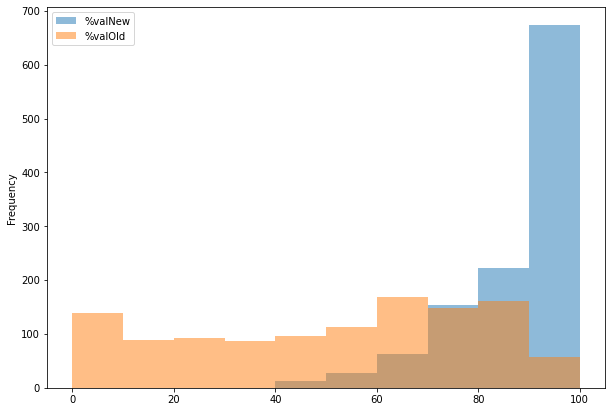

In [12]:
checks[["%valNew", "%valOld"]].plot.hist(figsize=(10, 7), alpha=0.5, bins=10)
plt.show()